In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
import warnings
warnings.filterwarnings('ignore')

from kats.consts import TimeSeriesData

# Lectura de datos

In [4]:
## https://www.kaggle.com/datasets/bobnau/daily-website-visitors/code
daily_website_df = pd.read_csv("../../kats/data/daily-website-visitors.csv")
daily_website_df.head()
# Function to remove commas
def remove_commas(x):
    return float(x.replace(',', ''))
# Apply the preprocessing functions

daily_website_df['Date'] = pd.to_datetime(daily_website_df['Date'])
daily_website_df['Page.Loads'] = daily_website_df['Page.Loads'].apply(lambda x : remove_commas(x))
daily_website_df['Unique.Visits'] = daily_website_df['Unique.Visits'].apply(lambda x : remove_commas(x))
daily_website_df['First.Time.Visits'] = daily_website_df['First.Time.Visits'].apply(lambda x : remove_commas(x))
daily_website_df['Returning.Visits'] = daily_website_df['Returning.Visits'].apply(lambda x : remove_commas(x))
daily_website_df['Day.Of.Week']
df_mask=daily_website_df['Day.Of.Week']==2
daily_website_df_monday = daily_website_df[df_mask]


daily_website_df.drop(['Row','Day','Day.Of.Week','Returning.Visits'],inplace=True,axis=1)
daily_website_df.columns = ["time", "PageLoads","UniqueVisits", "FirstTimeVisits" ]

daily_website_df_monday.drop(['Row','Day','Day.Of.Week','Returning.Visits'],inplace=True,axis=1)
daily_website_df_monday.columns = ["time", "PageLoads","UniqueVisits", "FirstTimeVisits" ]


## First study

In [5]:

daily_website_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PageLoads,2167.0,4116.989386,1350.977843,1002.0,3114.5,4106.0,5020.5,7984.0
UniqueVisits,2167.0,2943.646516,977.886472,667.0,2226.0,2914.0,3667.5,5541.0
FirstTimeVisits,2167.0,2431.824181,828.704688,522.0,1830.0,2400.0,3038.0,4616.0


## First visualitation

In [6]:
daily_website_ts = TimeSeriesData(daily_website_df)

daily_website_ts_monday = TimeSeriesData(daily_website_df_monday)

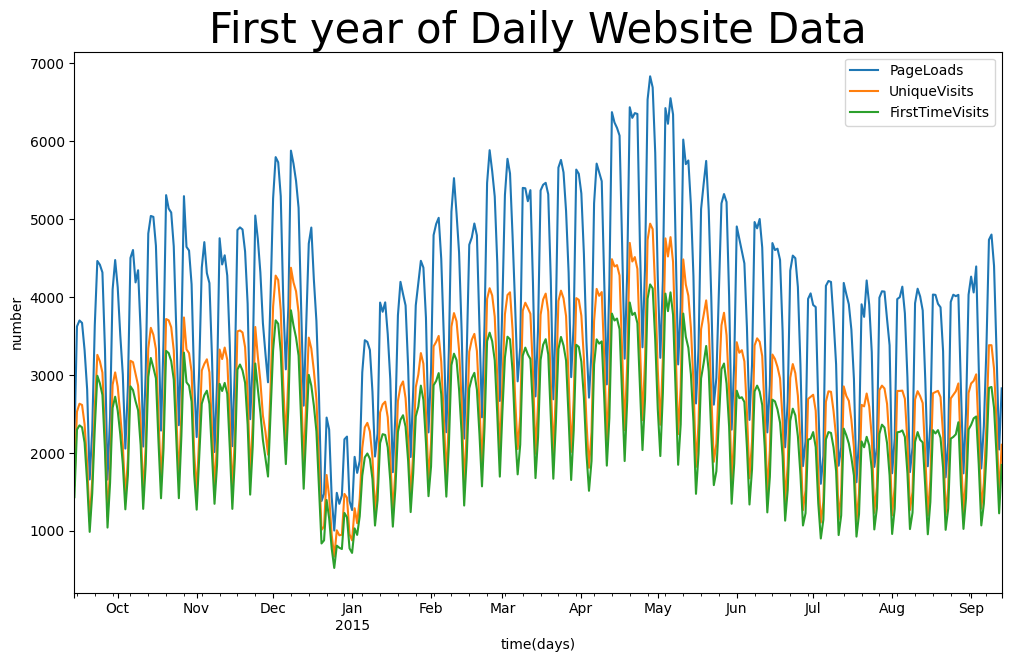

In [7]:
# We can plot multiple time series from multi_ts by passing in the name of each value column we want to plot
daily_website_ts[0:365].plot(cols=["PageLoads","UniqueVisits", "FirstTimeVisits"])
plt.title('First year of Daily Website Data', fontsize = 30)
plt.xlabel('time(days)')
plt.ylabel('number')
plt.savefig('../../images/DWD_first_year', bbox_inches = 'tight')

FileNotFoundError: [Errno 2] No such file or directory: '../..7images/DWD.png'

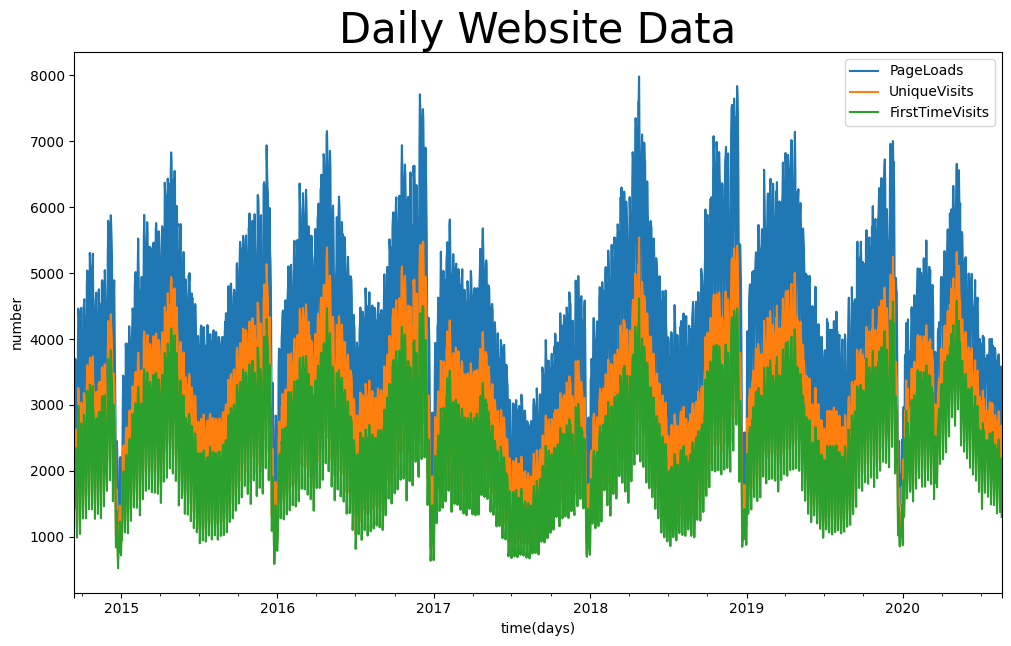

In [8]:
# We can plot multiple time series from multi_ts by passing in the name of each value column we want to plot
daily_website_ts.plot(cols=["PageLoads","UniqueVisits", "FirstTimeVisits"])
# fig = plt.figure()
plt.title('Daily Website Data', fontsize = 30)
plt.xlabel('time(days)')
plt.ylabel('number')
plt.savefig('../..7images/DWD', bbox_inches = 'tight')

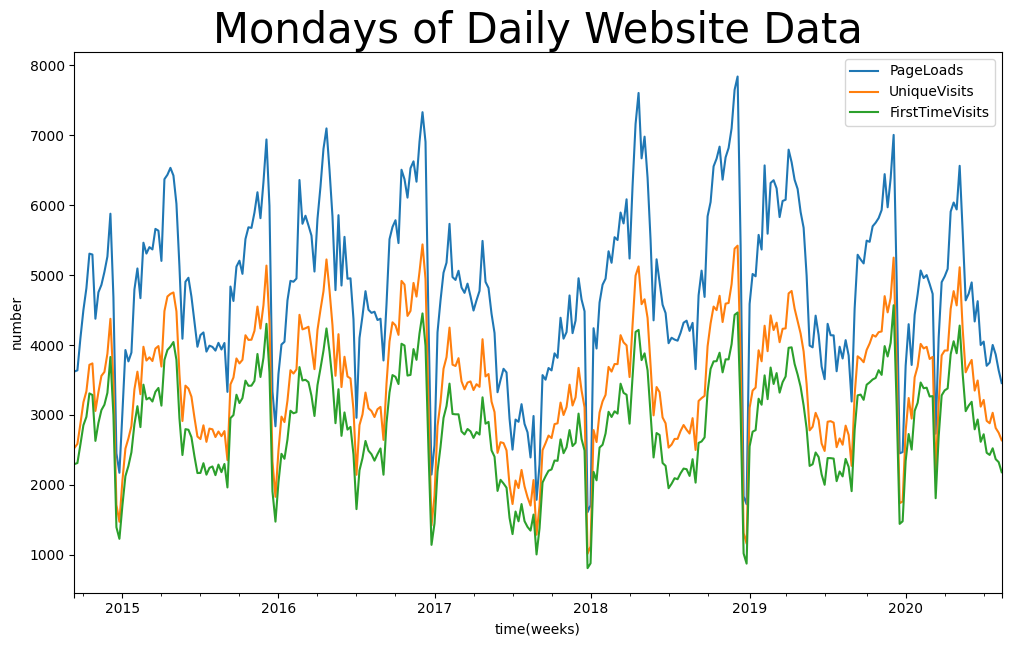

In [ ]:
# We can plot multiple time series from multi_ts by passing in the name of each value column we want to plot
daily_website_ts_monday.plot(cols=["PageLoads","UniqueVisits", "FirstTimeVisits"])
plt.title('Mondays of Daily Website Data', fontsize = 30)
plt.xlabel('time(weeks)')
plt.ylabel('number')
plt.savefig('../../images/DWD_mondays', bbox_inches = 'tight')

In [ ]:
daily_website_PL_ts = TimeSeriesData(daily_website_df.drop(['UniqueVisits','FirstTimeVisits'], axis=1))
daily_website_PL_ts

daily_website_UV_ts = TimeSeriesData(daily_website_df.drop(['PageLoads','FirstTimeVisits'], axis=1))
daily_website_UV_ts

daily_website_FTV_ts = TimeSeriesData(daily_website_df.drop(['PageLoads','UniqueVisits'], axis=1))
daily_website_FTV_ts

,time,FirstTimeVisits
0,2014-09-14,1430.0
1,2014-09-15,2297.0
2,2014-09-16,2352.0
3,2014-09-17,2327.0
4,2014-09-18,2130.0
...,...,...
2162,2020-08-15,1373.0
2163,2020-08-16,1686.0
2164,2020-08-17,2181.0
2165,2020-08-18,2184.0


# First comparative : PageLoads

In [ ]:
## HYPERPARAMETERS
import kats.utils.time_series_parameter_tuning as tpt
from kats.consts import ModelEnum, SearchMethodEnum, TimeSeriesData


from ax.core.parameter import ChoiceParameter, FixedParameter, ParameterType
from ax.models.random.sobol import SobolGenerator
from ax.models.random.uniform import UniformGenerator
warnings.simplefilter(action='ignore')

ts = daily_website_FTV_ts

## SARIMA

In [ ]:
from kats.models.sarima import SARIMAModel, SARIMAParams
parameters_grid_search = [
{
    "name": "p",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "d",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "q",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
}
]

parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)


# Divide into an 80/20 training-test split
split = int(0.8*len(ts))

train_ts = ts[0:split]
test_ts = ts[split:]

# Fit an ARIMA model and calculate the MAE for the test data
def evaluation_function(params):
    sarima_params = SARIMAParams(
        p = params['p'],
        d = params['d'],
        q = params['q']
    )
    model = SARIMAModel(train_ts, sarima_params)
    model.fit()
    model_pred = model.predict(steps=len(test_ts))
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error


parameter_tuner_grid.generate_evaluate_new_parameter_values(
    evaluation_function=evaluation_function
)

# Retrieve parameter tuning results

parameter_tuning_results_grid = (
    parameter_tuner_grid.list_parameter_value_scores()
)

parameter_tuning_results_grid

min = parameter_tuning_results_grid['mean'].min()

parameter_tuning_results_grid[parameter_tuning_results_grid['mean']==min].parameters.values[0]

{'p': 1, 'd': 1, 'q': 1}

In [ ]:
# create SARIMA param class
sarima_params = SARIMAParams(
    p = 1, 
    d = 1, 
    q = 1, 
    trend = 'ct', #both linear or constant
    seasonal_order=(0,0,0,7) # Becouse the data have a weekly behaivour
    )

## Linear y Cuadrático : sin parámetros

In [ ]:
from kats.models.linear_model import LinearModelParams, LinearModel
from kats.models.quadratic_model import QuadraticModelParams, QuadraticModel
lin_params = LinearModelParams()
qua_params = QuadraticModelParams()

## Stlf

In [ ]:
from kats.models.stlf import STLFModel, STLFParams
parameters_grid_search = [
{
    "name": "method",
    "type": "choice",
    "values": ['theta','linear','quadratic'] ,
    "value_type": "str",
    "is_ordered": True,
},
{
    "name": "m",
    "type": "choice",
    "values": [7,30,365],
    "value_type": "int",
    "is_ordered": True,
}
]

parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)

# Fit an ARIMA model and calculate the MAE for the test data
def evaluation_function(params):
    stlf_params =STLFParams(
        method = params['method'],
        m = params['m']
    )
    model =STLFModel(train_ts, stlf_params)
    model.fit()
    model_pred = model.predict(steps=len(test_ts))
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error


parameter_tuner_grid.generate_evaluate_new_parameter_values(
    evaluation_function=evaluation_function
)

# Retrieve parameter tuning results

parameter_tuning_results_grid = (
    parameter_tuner_grid.list_parameter_value_scores()
)

parameter_tuning_results_grid

min = parameter_tuning_results_grid['mean'].min()

parameter_tuning_results_grid[parameter_tuning_results_grid['mean']==min].parameters.values[0]

{'method': 'linear', 'm': 7}

In [ ]:
stlf_params = STLFParams(
    method = 'linear',
    m = 7
    )

## Harmonic Regression

In [ ]:
from kats.models.harmonic_regression import HarmonicRegressionModel, HarmonicRegressionParams
parameters_grid_search = [
{
    "name": "period",
    "type": "choice",
    "values": [7,30,360] ,
    "value_type": "float",
    "is_ordered": True,
},
{
    "name": "fourier_order",
    "type": "choice",
    "values": [4,5,6,7,8],
    "value_type": "int",
    "is_ordered": True,
}
]

parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)

# Fit an ARIMA model and calculate the MAE for the test data
def evaluation_function(params):
    hg_params =HarmonicRegressionParams(
        period = params['period'],
        fourier_order = params['fourier_order']
    )
    model =HarmonicRegressionModel(train_ts, hg_params)
    model.fit()
    model_pred = model.predict(dates  = test_ts.time)
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error


parameter_tuner_grid.generate_evaluate_new_parameter_values(
    evaluation_function=evaluation_function
)

# Retrieve parameter tuning results

parameter_tuning_results_grid = (
    parameter_tuner_grid.list_parameter_value_scores()
)

parameter_tuning_results_grid

min = parameter_tuning_results_grid['mean'].min()

parameter_tuning_results_grid[parameter_tuning_results_grid['mean']==min].parameters.values[0]

{'period': 7.0, 'fourier_order': 4}

In [ ]:
hr_params =HarmonicRegressionParams(
        period = 7,
        fourier_order = 4
    )

## Evaluación de modelos

In [ ]:
from kats.utils.backtesters import BackTesterSimple


backtester_simple_errors = {}
ALL_ERRORS = ['mae','mape', 'mase', 'mse', 'rmse', 'smape']

###############################################################################

backtester_simple_sarima = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=ts,
    params= sarima_params,
    train_percentage=80,
    test_percentage=20, 
    model_class=SARIMAModel)

backtester_simple_sarima.run_backtest()

backtester_simple_errors['sarima'] = {}
for error, value in backtester_simple_sarima.errors.items():
    backtester_simple_errors['sarima'][error] = value

# ###############################################################################
# backtester_simple_hr = BackTesterSimple(
#     error_methods=ALL_ERRORS,
#     data=ts,
#     params= hr_params,
#     train_percentage=80,
#     test_percentage=20, 
#     model_class=HarmonicRegressionModel)

# backtester_simple_hr.run_backtest()

# backtester_simple_errors['harmonic-regression'] = {}
# for error, value in backtester_simple_hr.errors.items():
#     backtester_simple_errors['harmonic-regression'][error] = value


###############################################################################
backtester_simple_lin = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=ts,
    params = lin_params,
    train_percentage=80,
    test_percentage=20, 
    model_class= LinearModel)

backtester_simple_lin.run_backtest()

backtester_simple_errors['linear'] = {}
for error, value in backtester_simple_lin.errors.items():
    backtester_simple_errors['linear'][error] = value

###############################################################################
backtester_simple_qua = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=ts,
    params = qua_params,
    train_percentage=80,
    test_percentage=20, 
    model_class= QuadraticModel)

backtester_simple_qua.run_backtest()

backtester_simple_errors['quadratic'] = {}
for error, value in backtester_simple_qua.errors.items():
    backtester_simple_errors['quadratic'][error] = value

###############################################################################
backtester_simple_stlf = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=ts,
    params = stlf_params,
    train_percentage=80,
    test_percentage=20, 
    model_class= STLFModel)

backtester_simple_stlf.run_backtest()

backtester_simple_errors['stlf'] = {}
for error, value in backtester_simple_stlf.errors.items():
    backtester_simple_errors['stlf'][error] = value


pd.DataFrame.from_dict(backtester_simple_errors) 

,sarima,linear,quadratic,stlf
mae,637.129786,641.089570,684.475664,538.744929
mape,0.298674,0.290860,0.349806,0.234016
mase,1.521521,1.530977,1.634587,1.286569
mse,613696.144566,635067.346211,673915.133477,423411.000768
rmse,783.387608,796.911128,820.923342,650.700392
smape,0.258348,0.260087,0.274069,0.220206


## Ensemble

In [ ]:
from kats.models.ensemble.ensemble import EnsembleParams, BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
model_ensemble_params = EnsembleParams(
            [
                BaseModelParams("sarima",sarima_params),
                BaseModelParams("linear", lin_params),
                BaseModelParams("quadratic", qua_params)
                # BaseModelParams("stlf", stlf_params)
            ]
        )

from kats.models.ensemble.bates_granger_ensemble import BatesGrangerEnsemble
from kats.models.ensemble.weighted_avg_ensemble import WeightedAvgEnsemble
from kats.models.ensemble.mean_ensemble import MeanEnsembleModel
from kats.models.ensemble.median_ensemble import MedianEnsembleModel


In [ ]:
backtester_ensemble_errors = {}
ALL_ERRORS = ['mae','mape', 'mase', 'mse', 'rmse', 'smape']
###############################################################################
backtester_ensemble_median = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=ts,
    params= model_ensemble_params,
    train_percentage=80,
    test_percentage=20,
    model_class=MedianEnsembleModel)

backtester_ensemble_median.run_backtest()

backtester_ensemble_errors['median'] = {}
for error, value in backtester_ensemble_median.errors.items():
    backtester_ensemble_errors['median'][error] = value
###############################################################################
backtester_ensemble_mean = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=ts,
    params= model_ensemble_params,
    train_percentage=80,
    test_percentage=20, 
    model_class=MeanEnsembleModel)

backtester_ensemble_mean.run_backtest()

backtester_ensemble_errors['mean'] = {}
for error, value in backtester_ensemble_mean.errors.items():
    backtester_ensemble_errors['mean'][error] = value
###############################################################################
backtester_ensemble_weighted_average = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=ts,
    params= model_ensemble_params,
    train_percentage=80,
    test_percentage=20, 
    model_class=WeightedAvgEnsemble)

backtester_ensemble_weighted_average.run_backtest()

backtester_ensemble_errors['weighted_average'] = {}
for error, value in backtester_ensemble_weighted_average.errors.items():
    backtester_ensemble_errors['weighted_average'][error] = value
###############################################################################

backtester_ensemble_bates_granger = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=ts,
    params= model_ensemble_params,
    train_percentage=80,
    test_percentage=20, 
    model_class=BatesGrangerEnsemble)

backtester_ensemble_bates_granger.run_backtest()

backtester_ensemble_errors['bates&granger'] = {}
for error, value in backtester_ensemble_bates_granger.errors.items():
    backtester_ensemble_errors['bates&granger'][error] = value

pd.DataFrame.from_dict(backtester_ensemble_errors) 

,median,mean,weighted_average,bates&granger
mae,637.129786,643.274269,645.359679,644.350637
mape,0.298674,0.308977,0.311939,0.310394
mase,1.521521,1.536194,1.541174,1.538765
mse,613696.144566,611460.964944,612648.979741,612268.703163
rmse,783.387608,781.959695,782.718966,782.476008
smape,0.258348,0.260482,0.261196,0.260860


In [ ]:
pd.DataFrame.from_dict(backtester_ensemble_errors).round(2)


,median,mean,weighted_average,bates&granger
mae,637.13,643.27,645.36,644.35
mape,0.30,0.31,0.31,0.31
mase,1.52,1.54,1.54,1.54
mse,613696.14,611460.96,612648.98,612268.70
rmse,783.39,781.96,782.72,782.48
smape,0.26,0.26,0.26,0.26


In [ ]:
pd.DataFrame.from_dict(backtester_simple_errors).round(2)

,sarima,linear,quadratic,stlf
mae,637.13,641.09,684.48,538.74
mape,0.30,0.29,0.35,0.23
mase,1.52,1.53,1.63,1.29
mse,613696.14,635067.35,673915.13,423411.00
rmse,783.39,796.91,820.92,650.70
smape,0.26,0.26,0.27,0.22


In [ ]:
var_simple = pd.DataFrame.from_dict(backtester_simple_errors).T.var().values
print(var_simple.round(2))
var_ensemble = pd.DataFrame.from_dict(backtester_ensemble_errors).T.var().values
print(var_ensemble.round(2))

coc = var_simple/var_ensemble

df = pd.DataFrame(index = ['mae', 'mape', 'mase', 'mse', 'rmse', 'smape'], columns=['Simple','Ensemble','Cociente de var'] )#, data=[var_simple,var_ensemble,coc])
df['Simple'] = var_simple.round(4)
df['Ensemble'] = var_ensemble.round(4)
df['Cociente de var'] = coc.round()

df

[3.79426000e+03 0.00000000e+00 2.00000000e-02 1.24459475e+10
 5.84398000e+03 0.00000000e+00]
[1.3680000e+01 0.0000000e+00 0.0000000e+00 8.6155013e+05 3.5000000e-01
 0.0000000e+00]


,Simple,Ensemble,Cociente de var
mae,3.794260e+03,13.6793,277.0
mape,2.200000e-03,0.0000,62.0
mase,2.160000e-02,0.0001,277.0
mse,1.244595e+10,861550.1279,14446.0
rmse,5.843978e+03,0.3516,16621.0
smape,5.000000e-04,0.0000,324.0


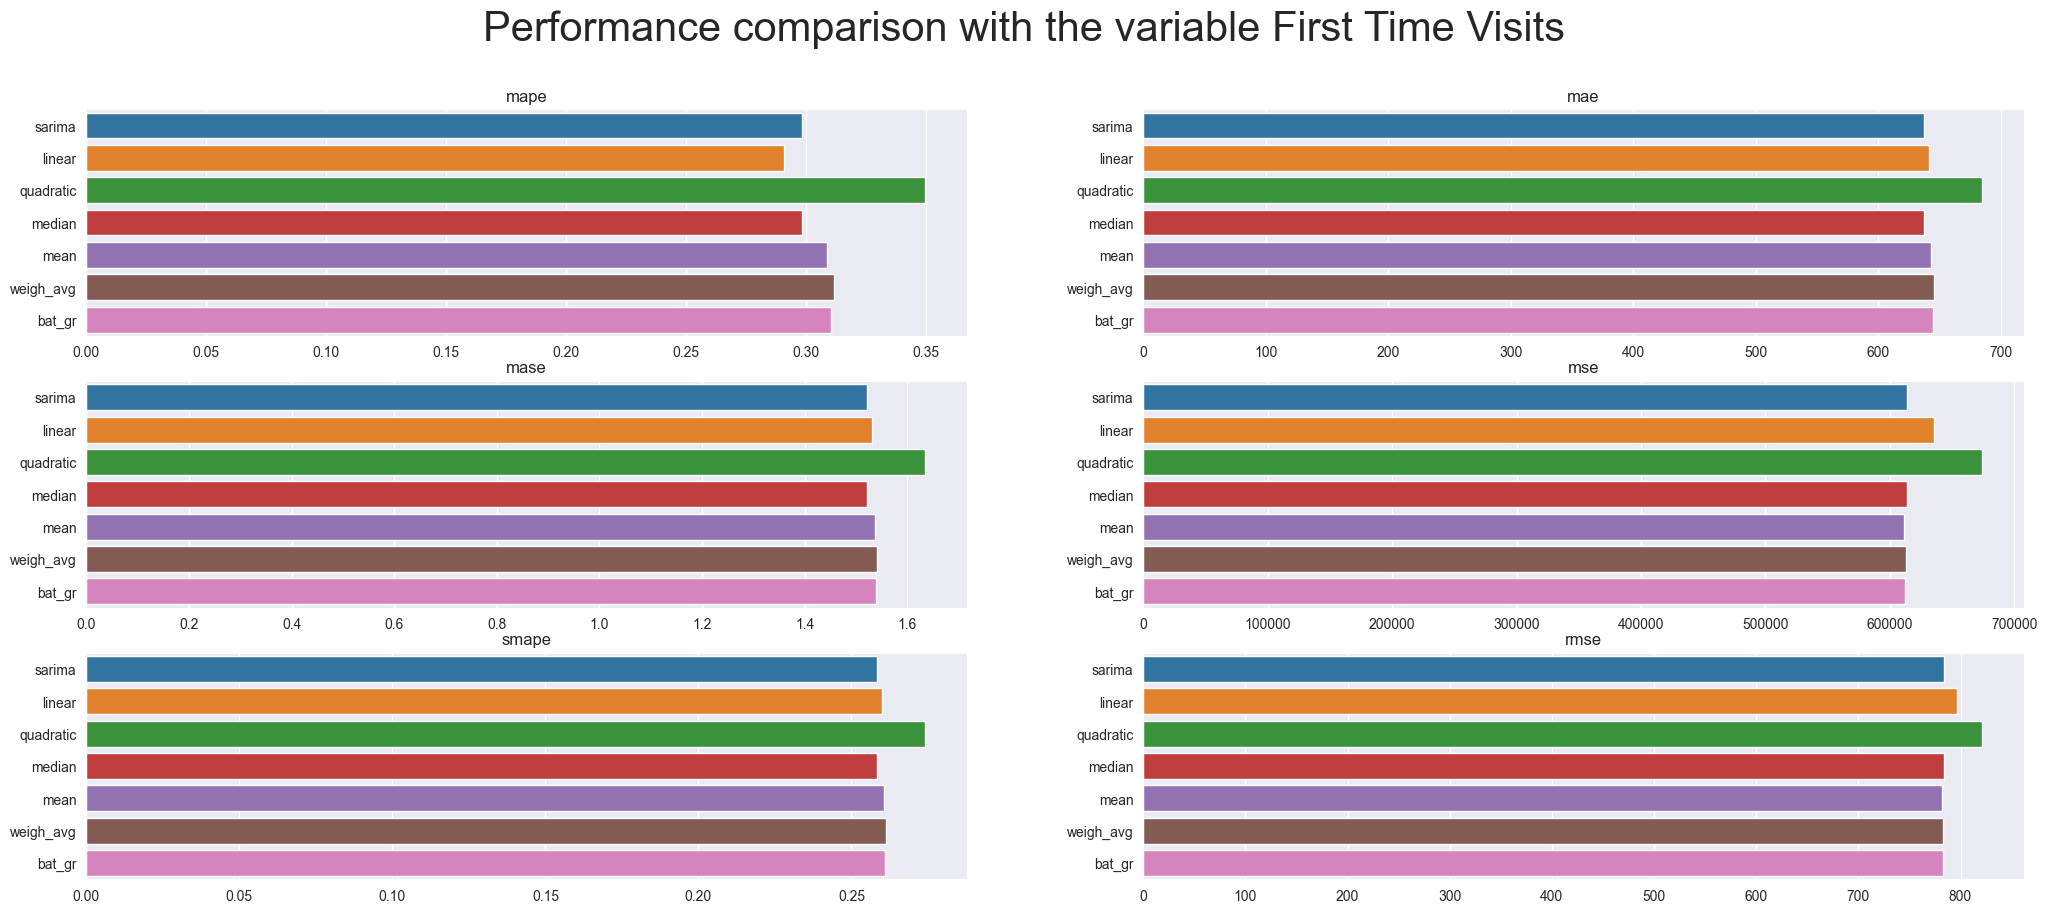

In [ ]:
# TODOS JUNTOS 
df_complete = pd.concat([pd.DataFrame.from_dict(backtester_simple_errors).drop(['stlf'], axis=1),pd.DataFrame.from_dict(backtester_ensemble_errors)], axis=1).T

# df_complete.index = ['s','a','p','h','t','me','wa','bg']
# df_complete.index[6] = 'weigh_avg'
# df_complete.index[7] = 'bat_gr'
df_complete.index = ['sarima', 'linear', 'quadratic','median','mean','weigh_avg', 'bat_gr']

import seaborn as sns
sns.set_style("darkgrid")
def comparative_barplot(err,i,j):
    
    p = sns.barplot(
        x = err,
        y = df_complete.index,
        data = df_complete,
        ax = ax[i][j]
        
    )
    p.set(title= err)
    p.set_xlabel('')

error = ["mape","mase","smape","mae","mse","rmse"]

fig, ax = plt.subplots(3, 2)
# plt.rc('font', size = 15)
# fig.suptitle('Comparison of the different types of errors', fontsize = 40, fontfamily ='DejaVu Sans' )


i = 0
for e in error[0:3]:
    comparative_barplot(e,i,0) 
    i = i+1

i = 0
for e in error[3:7]:
    comparative_barplot(e,i,1) 
    i = i+1

# fig.tight_layout()
fig.set_size_inches(25, 10)
fig.suptitle('Performance comparison with the variable First Time Visits', fontsize = 30)

plt.savefig('../../images/DWD_FTV_comparative_errors', bbox_inches='tight')